###Load data

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
path = "/content/drive/MyDrive/Data/all_data.csv"
df = pd.read_csv(path)

In [27]:
df['tags'].value_counts()

murder                                                                                           1004
romantic                                                                                          731
violence                                                                                          584
psychedelic                                                                                       437
flashback                                                                                         332
                                                                                                 ... 
paranormal, cult, comedy, murder, home movie                                                        1
cruelty, murder, cult, horror, violence, haunting, flashback, insanity, revenge, storytelling       1
good versus evil, violence, fantasy, action                                                         1
pornographic, psychedelic, humor, satire                                          

In [89]:
selected = ['murder']
df_new = pd.DataFrame(df.loc[df['tags'].isin(selected)])

In [65]:
# df_new[:10]

In [90]:
import re
df1 = pd.DataFrame(df_new['plot_synopsis'].str.replace(r"\([^()]*\)","") )  #new dataframe with only 3 tags 
#df1 = pd.DataFrame(df['plot_synopsis'].str.replace(r"\([^()]*\)","") )   

In [79]:
len(df1)

14828

### Pre-processing

In [80]:
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download("punkt")
#Create Stop Words Corpus
stop_words = nltk.corpus.stopwords.words("english")
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
# add_stopw = ['go','tell', 'find','get','back','take','say','make','one','see','ask','come','call','give']
# add_stopw2 = ['kill', 'help','leave', 'escape','return','force']
# add_stopw3 = ['fight','battle','attack','shoot']

# stop_words = add_stopw + stop_words + add_stopw2 + add_stopw3

In [34]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
stop_spacy = en.Defaults.stop_words
print(len(stop_spacy))

326


In [81]:
final_stop_list =  stop_words + list(stop_spacy - set(stop_words))

In [82]:
len(final_stop_list) 

382

In [83]:
def preprocess(document):
    
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    
    words = [w for w in words if not w in final_stop_list and len(w)>3 and len(w)<10] # Removing stopwords and words with less than 2 letters
    
    return " ".join(words)
    

In [91]:
df1['processed_plot'] = df1['plot_synopsis'].apply(preprocess)
df1.head()

,plot_synopsis,processed_plot
13,Arrival.\nA train pulls into a station in Nort...,arrival train pull station north china soldier...
30,"** CONTAINS SPOILERSIn England, OFFICIALS drag...",contain england official drag lake soon locate...
56,Divorcée Hazel Show and her teenage daughter L...,divorc hazel teenage daughter laurie small ami...
72,Mel and Jules are best friends returning to ...,jules best friend return angeles trip mexico s...
102,A young Hispanic woman prays to the Virgin Mar...,young hispanic woman pray virgin mary grip lig...


### Split train and test set

In [15]:
# from sklearn.model_selection import train_test_split

# df_train, df_test = train_test_split(df1, test_size=0.2)

In [16]:
df_test

,plot_synopsis,processed_plot
9007,The story is narrated through flashbacks. Velu...,story narrate flashback velu teenager work roa...
12983,The show follows three best friends in their l...,follow best friend late live kahnawake bailey ...
8722,"The film centers on European-looking, South Am...",film center european look south american immig...
2144,"Pittsburgh, 1996. Jamie is seen working in an...",jamie work store talk flirt woman phone stereo...
7247,"In a Colorado national park, a boy having an a...",colorado national park asthma attack approach ...
...,...,...
6636,The film begins in 1944 with John Christie mur...,film begin john christie murder neighbour muri...
792,"In mid-August 1939, just before the outbreak o...",august outbreak world editor york globe power ...
11856,Naive country girl Lili arrives in a provinci...,naive country girl lili arrive town hope locat...
1401,CONTIENE SPOILERS\nLa película trata la histor...,contiene spoiler cula trata historia ladrones ...


### Vectorize

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
#X = vectorizer.fit_transform(df_train['processed_plot'])
X = vectorizer.fit_transform(df1['processed_plot'])
vocab_tf_idf = vectorizer.get_feature_names()
print(X.shape)

(1004, 16746)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer2 = CountVectorizer(strip_accents='unicode',min_df=0.1,max_df=0.4)
#X2 = vectorizer2.fit_transform(df_train['processed_plot'])
X2 = vectorizer2.fit_transform(df1['processed_plot'])
vocab2 = vectorizer2.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Train LDA

In [95]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
#model = LDA(n_components=20,doc_topic_prior=50/20, topic_word_prior=0.01 )
model = LDA(n_components=5)
X_topics = model.fit_transform(X)  

In [62]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
model2 = LDA(n_components=2)
X2_topics = model2.fit_transform(X2)

### Plot perplexity

In [67]:
score_test = []
score_train = []
featureshape = []
for (min,max) in [(0.01,0.6),(0.02,0.2),(0.05,0.8),(0.1,0.6),(0.1,0.8),(0.2,0.6),(0.2,0.8)]:
  vectorizer2 = CountVectorizer(strip_accents='unicode',min_df=min,max_df=max)
  X2 = vectorizer2.fit_transform(df_train['processed_plot'])
  X2_test = vectorizer2.transform(df_test['processed_plot'])
  featureshape.append(X2.shape[1])
  model2.fit_transform(X2)
  model2.fit(X2_test)
  score_train.append(model2.perplexity(X2))
  score_test.append(model2.perplexity(X2_test))
  

In [63]:
tf_score_test = []
tf_score_train = []
for (min,max) in [(0.01,0.6),(0.02,0.2),(0.05,0.8),(0.1,0.6),(0.1,0.8),(0.2,0.6),(0.2,0.8)]:
  vectorizer = TfidfVectorizer(min_df=min,max_df=max)
  X1 = vectorizer.fit_transform(df_train['processed_plot'])
  X1_test = vectorizer.transform(df_test['processed_plot'])
  model.fit_transform(X1)
  model.fit(X1_test)
  tf_score_train.append(model.perplexity(X1))
  tf_score_test.append(model.perplexity(X1_test))
  

In [38]:
doc_fre = ['0.01,0.6','0.02,0.2','0.05,0.8','0.1,0.6','0.1,0.8','0.2,0.6','0.2,0.8']

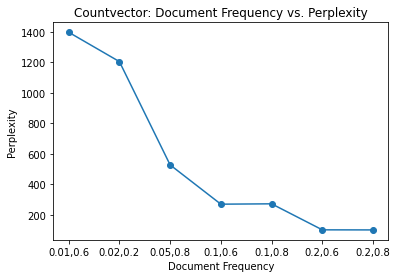

In [39]:
import matplotlib.pyplot as plt
plt.plot(doc_fre,score_test)
plt.scatter(doc_fre,score_test)
plt.title('Countvector: Document Frequency vs. Perplexity')
plt.xlabel('Document Frequency')
plt.ylabel('Perplexity')
plt.xticks(doc_fre)
plt.show()

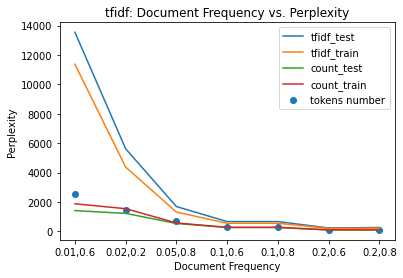

In [68]:
import matplotlib.pyplot as plt
plt.plot(doc_fre,tf_score_test,label='tfidf_test')
plt.plot(doc_fre, tf_score_train,label='tfidf_train')
plt.plot(doc_fre,score_test,label='count_test')
plt.plot(doc_fre, score_train,label='count_train')
plt.scatter(doc_fre,featureshape, label='tokens number')
plt.title('tfidf: Document Frequency vs. Perplexity')
plt.xlabel('Document Frequency')
plt.ylabel('Perplexity')
plt.xticks(doc_fre)
plt.legend();

### Document topics matrix

In [21]:
'''
credit to: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#8checkthesparsicity
'''
# Create Document - Topic Matrix
lda_output = model.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_train))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
df_doc_top = df_document_topic.copy()

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [23]:
'''
credit to: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#8checkthesparsicity
'''
# Create Document - Topic Matrix
lda_output2 = model.transform(X2)

# column names
topicnames2 = ["Topic" + str(i) for i in range(model2.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_train))]

# Make the pandas dataframe
df_document_topic2 = pd.DataFrame(np.round(lda_output2, 2), columns=topicnames2, index=docnames)
df_doc_top2 = df_document_topic2.copy()

# Get dominant topic for each document
dominant_topic2 = np.argmax(df_document_topic2.values, axis=1)
df_document_topic2['dominant_topic'] = dominant_topic2

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics2 = df_document_topic2.head(15).style.applymap(color_green).applymap(make_bold)

In [25]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic ID', 'Num of Docs']
df_topic_distribution

,Topic ID,Num of Docs
0,1,803


In [26]:
df_topic_distribution2 = df_document_topic2['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution2.columns = ['Topic ID', 'Num of Docs']
df_topic_distribution2.head()

,Topic ID,Num of Docs
0,1,803


### topic lists

In [63]:
import numpy as np
n_topic_words = 10
topic_words2 = model2.components_
for i, topic_dist in enumerate(topic_words2):
  sorted_topic_dist = np.argsort(topic_dist)

  topic_words2 = np.array(vocab2)[sorted_topic_dist]

  topic_words2 = topic_words2[:-n_topic_words:-1]
  print("Topic", str(i+1), topic_words2)

Topic 1 ['police' 'house' 'room' 'body' 'look' 'night' 'dead' 'turn' 'head']
Topic 2 ['father' 'family' 'marry' 'mother' 'year' 'young' 'daughter' 'wife'
 'child']


In [96]:
import numpy as np
n_topic_words = 10
topic_words = model.components_

for i, topic_dist in enumerate(topic_words):
  sorted_topic_dist = np.argsort(topic_dist)

  topic_words = np.array(vocab_tf_idf)[sorted_topic_dist]

  topic_words = topic_words[:-n_topic_words:-1]
  print("Topic", str(i+1), topic_words)


Topic 1 ['mick' 'oliver' 'aryan' 'gaurav' 'ritch' 'hildern' 'lorraine' 'sikes'
 'aladeen']
Topic 2 ['perry' 'rommel' 'wyatt' 'sara' 'richter' 'weston' 'craig' 'ravi' 'raam']
Topic 3 ['marianne' 'olive' 'rynn' 'dany' 'arlis' 'tartu' 'masuoka' 'chava'
 'milner']
Topic 4 ['kill' 'find' 'tell' 'police' 'murder' 'house' 'shoot' 'father' 'woman']
Topic 5 ['kolchak' 'bert' 'macbeth' 'joanna' 'khan' 'tibbs' 'rasputin' 'libby'
 'flemming']


### Topic plot

In [42]:
#https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
'''
Plots code from sklearn
'''
from time import time
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(13,6), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 15})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    plt.subplots_adjust(top=0.80, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

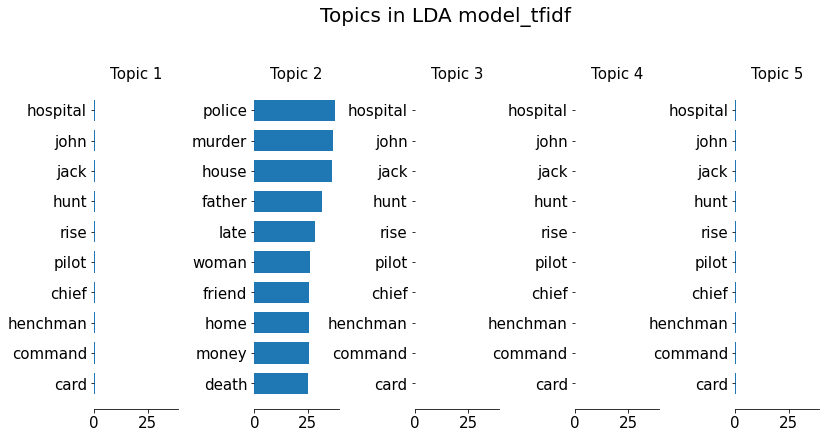

In [43]:
tf_feature_names1 = vocab_tf_idf
n_top_words = 10
plot_top_words(model, tf_feature_names1, n_top_words, "Topics in LDA model_tfidf")

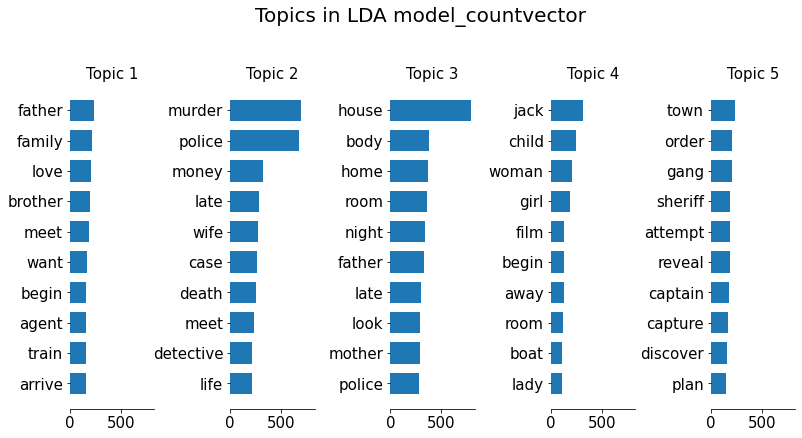

In [44]:
tf_feature_names2 = vocab2
n_top_words = 10
plot_top_words(model2, tf_feature_names2, n_top_words, "Topics in LDA model_countvector")

### Wordcloud

In [185]:
text = df_train.processed_plot.iloc[1]

In [186]:
#text = text_tokens.iloc[0]
str1 = ','.join(text.split(' '))

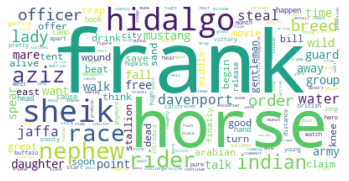

In [188]:
# Create and generate a word cloud image:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white').generate(str1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

### Topic assignment to movie

In [189]:
doc_topic = model.transform(X) #https://www.analyticsvidhya.com/blog/2021/06/part-3-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/

for n in range(10):
  topic_doc = doc_topic[n].argmax()

  print("Movie", n+1, " -- Topic:", topic_doc)

Movie 1  -- Topic: 1
Movie 2  -- Topic: 1
Movie 3  -- Topic: 1
Movie 4  -- Topic: 1
Movie 5  -- Topic: 1
Movie 6  -- Topic: 1
Movie 7  -- Topic: 1
Movie 8  -- Topic: 1
Movie 9  -- Topic: 1
Movie 10  -- Topic: 1


In [190]:
doc_topic2 = model2.transform(X2) #https://www.analyticsvidhya.com/blog/2021/06/part-3-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/

for n in range(10):
  topic_doc = doc_topic2[n].argmax()

  print("Movie", n+1, " -- Topic:", topic_doc)

Movie 1  -- Topic: 3
Movie 2  -- Topic: 3
Movie 3  -- Topic: 2
Movie 4  -- Topic: 2
Movie 5  -- Topic: 1
Movie 6  -- Topic: 3
Movie 7  -- Topic: 3
Movie 8  -- Topic: 3
Movie 9  -- Topic: 1
Movie 10  -- Topic: 4


In [27]:
#https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
#coherence score

### Coherence score

In [191]:
import spacy
import nltk
import re
import string
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
#import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [192]:
syn_text2 = df1.processed_plot.map(lambda x: [word for word in x.split()])

In [ ]:
dictionary2 = corpora.Dictionary(syn_text2)
doc_term_matrix2 = [dictionary2.doc2bow(doc) for doc in syn_text2]

In [ ]:
#while True:pass
coherence_topic = []
for k in [5,6,10]:
#for k in range(6,12):
    print('Round: '+str(k))
    Lda2 = gensim.models.ldamodel.LdaModel
    # ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
    #                iterations=200, chunksize = 10000, eval_every = None)
    ldamodel2 = Lda2(doc_term_matrix2, num_topics=k, id2word = dictionary2, eval_every=None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel2, texts=syn_text2,\
                                                     dictionary=dictionary2, coherence='c_v')
    coherence_topic.append((k,cm.get_coherence()))

In [ ]:
x_val_t = [x[0] for x in coherence_topic]
y_val_t = [x[1] for x in coherence_topic]

In [ ]:
plt.plot(x_val_t,y_val_t)
plt.scatter(x_val_t,y_val_t)
plt.title('Number of topics vs. Coherence')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.xticks(x_val_t)
plt.show()

In [ ]:
coherence = []
for al in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print('Alpha: '+str(al))
    Lda = gensim.models.ldamodel.LdaModel
    # ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
    #                iterations=200, chunksize = 10000, eval_every = None)
    ldamodel = Lda(doc_term_matrix2, num_topics=2, alpha=al, id2word = dictionary2)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=syn_text2,\
                                                     dictionary=dictionary2, coherence='c_v')
    coherence.append((al,cm.get_coherence()))

In [ ]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

In [ ]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Alpha vs. Coherence')
plt.xlabel('Alpha')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [ ]:
coherence_eta = []
for eta in [0.001,0.01, 0.1, 0.4, 0.5]:
    print('Eta: '+str(eta))
    Lda2 = gensim.models.ldamodel.LdaModel
    # ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
    #                iterations=200, chunksize = 10000, eval_every = None)
    ldamodel2 = Lda2(doc_term_matrix2, num_topics=5, eta=eta, alpha=10, id2word = dictionary2)
    
    cm2 = gensim.models.coherencemodel.CoherenceModel(model=ldamodel2, texts=syn_text2,\
                                                     dictionary=dictionary2, coherence='c_v')
    coherence_eta.append((eta,cm2.get_coherence()))

In [ ]:
coherence_eta

In [ ]:
x_val2 = [x[0] for x in coherence_eta]
y_val2 = [x[1] for x in coherence_eta]

In [ ]:
plt.plot(x_val2,y_val2)
plt.scatter(x_val2,y_val2)
plt.title('Eta vs. Coherence, alpha=0.8')
plt.xlabel('Eta')
plt.ylabel('Coherence')
plt.xticks(x_val2)
plt.show()

In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix2, num_topics=20, alpha=50/20, eta=0.01, random_state=3, id2word = dictionary2)

In [ ]:
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix2, num_topics=4, alpha=50/4, eta=0.01, random_state=3, id2word = dictionary2)

In [ ]:
# To show initial topics
ldamodel.show_topics(20, num_words=5, formatted=False)

In [ ]:
# To show initial topics
ldamodel2.show_topics(4, num_words=10, formatted=False)